In [1]:
import torch

In [2]:
import torch.utils.data as data
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

<ipython-input-2-326c51e217da>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [27]:
def sigmoid(x):
    z = np.exp(-x)
    zz = 1.0 + z
    zzz = 1.0/zz
    return zzz
def sigmoid_prime(x):
    return sigmoid(x)*(1.0 - sigmoid(x))


In [26]:
class Layer:
  def __init__(self, input_size, output_size, act_func, act_func_prime):
    self.input_size = input_size
    self.output_size = output_size
    self.act_func = act_func
    self.act_func_prime = act_func_prime
    self.bias = np.random.rand(output_size, 1) / 20
    self.weights = np.random.rand(self.output_size, self.input_size) / 20
  def forward(self, input):
    x = np.copy(input)
    # print(self.weights.shape, x.shape, self.bias.shape)
    # print("forward")
    z = np.matmul(self.weights, x) + self.bias
    self.input = np.copy(input)
    self.activation = self.act_func(z)
    # print(x.shape, self.weights.shape, self.activation.shape, self.bias.shape, np.matmul(self.weights, x).shape)
    self.prime = self.act_func_prime(z)
    return self.activation
  def backward(self, error, sz):
    # print("backward")
    dl_dz = np.multiply(error, self.prime)
    # print(error.shape, self.activation.shape, dl_dz.shape, self.weights.shape, self.input.shape)
    # print(dl_dz.shape, self.input.shape)
    # print(dl_dz.shape, self.input.shape)
    self.dl_dw = np.matmul(dl_dz, self.input.T)
    self.dl_db = np.sum(dl_dz, axis=1)
    # print(self.dl_dw.shape, self.weights.shape)
    # print(self.dl_db.shape, self.bias.shape, dl_dz.shape)
    # print(dl_dz.shape, self.weights.shape)
    err = np.matmul(self.weights.T, dl_dz)
    return err
  def update_weights(self, lr):
    self.weights -= lr * self.dl_dw
    # print("update weights")
    # print(self.bias.shape, self.dl_db.shape)
    self.bias -= lr*self.dl_db.reshape(-1,1)

In [5]:
from sklearn.metrics import accuracy_score

In [46]:
class Perceptron:
    def __init__(self, input_size, layer_sizes, loss_func, loss_prime_func, accu_func):
      self.layers = []
      self.layers.append(Layer(input_size, layer_sizes[0], sigmoid, sigmoid_prime))
      for i in range(1, len(layer_sizes)):
        self.layers.append(Layer(layer_sizes[i - 1], layer_sizes[i], sigmoid, sigmoid_prime))
      self.loss = loss_func
      self.loss_prime = loss_prime_func
      self.accu_func = accu_func
    def forward(self, input):
      self.input = input
      x = np.copy(input)
      for i in range(len(self.layers)):
        x = self.layers[i].forward(x)
      self.output = np.copy(x)
      return self.output
    def backward(self, error, sz, lr):
      err = np.copy(error)
      for i in range(len(self.layers)):
        err = self.layers[len(self.layers) - i - 1].backward(err, sz)
        self.layers[len(self.layers) - i - 1].update_weights(lr)
    def train(self, train_dataset, test_dataset, lr = 0.001, epoch = 100):
      loss_array = []
      accu_array = []
      for i in range(epoch):
        loss_el = 0;
        for input, output in train_dataset:
          input = input.permute(1, 0)
          output = output.permute(1, 0)
          # outout = outpu
          sz = output.shape[0]
          # print(sz)
          self.forward(input)
          loss_el += np.mean(self.loss(output.numpy(), self.output))
          # print("train", output.numpy().shape, self.output.shape, self.loss_prime(output, self.output).shape)
          self.backward(self.loss_prime(output, self.output), sz, lr)
        accu_array.append(self.accu_func(test_dataset, self))
        # print("loss =", loss_el/len(dataset))
        loss_array.append(loss_el / len(train_dataset))
      return loss_array, accu_array

In [7]:
def loss(y_true, y_pred):
        """
        Function to compute cross-entropy loss per sample

        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of prediction values
        Output:
            loss value
        """
        return -y_true*np.log(y_pred) - (1.0 - y_true)*np.log(1.0 - y_pred)

def derivative_loss(y_true, y_pred):
    """
    Function to compute the derivative of the cross-entropy loss per sample

    Inputs:
        y_true -> numpy array of true labels
        y_pred -> numpy array of prediction values
    Output:
        loss value
    """
    return -y_true/y_pred + (1.0 - y_true) / (1.0 - y_pred)

In [8]:
def draw_plot(loss):
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [9]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

In [10]:
from google.colab import drive

# Аутентификация и монтирование Google Диска
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [12]:
#
# Set file paths based on added MNIST Datasets
#
input_path = ''
training_images_filepath = join(input_path, 'drive/MyDrive/train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'drive/MyDrive/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 'drive/MyDrive/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 'drive/MyDrive/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


In [13]:
def digit_to_array(digit):
    # Проверяем, что введенное значение - цифра от 0 до 9
    if not isinstance(digit, int) or digit < 0 or digit > 9:
        raise ValueError("Input must be an integer between 0 and 9")

    # Создаем массив из 10 нулей
    result = [0] * 10
    # Устанавливаем 1 на позиции, соответствующей цифре
    result[digit] = 1
    return result

In [28]:
class MNISTDataset(data.Dataset):

    def __init__(self, x_data, y_data):
        super().__init__()
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        data_point = torch.tensor(np.array(self.x_data[idx]) / 255).reshape(-1)
        data_label = torch.tensor(np.array(digit_to_array(self.y_data[idx])))
        return data_point, data_label

In [29]:
mnist_train_dataset = MNISTDataset(x_train, y_train)
mnist_test_dataset = MNISTDataset(x_test, y_test)

In [30]:
mnist_train_data_loader = data.DataLoader(mnist_train_dataset, batch_size=1, shuffle=True)
mnist_test_data_loader = data.DataLoader(mnist_test_dataset, batch_size=1, shuffle=True)

In [47]:
def accu_function(dataloader, model):
  good_answer_count = 0
  all_answer_count = 0
  for x, y in dataloader:
    # print(y)
    pred = model.forward(x.permute(1,0))
    max_ans = max(pred)
    for i in range(pred.size):
      if y.numpy()[0][i] == 1:
        if pred[i] == max_ans:
          good_answer_count += 1
        all_answer_count += 1
  return good_answer_count / all_answer_count

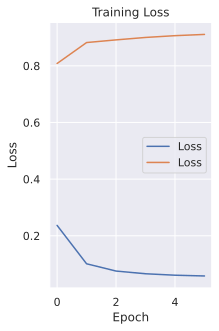

In [48]:
mnist_perc = Perceptron(28 * 28, [10, 10], loss, derivative_loss, accu_function)
mnist_loss, mnist_accu = mnist_perc.train(mnist_train_data_loader, mnist_test_data_loader, 0.005, 6)

draw_plot(mnist_loss)
draw_plot(mnist_accu)

In [49]:
print(mnist_accu, mnist_loss)

[0.8083, 0.8822, 0.8916, 0.9002, 0.9065, 0.9109] [0.23654270784784664, 0.10098880646012115, 0.07530216066701706, 0.06579280335324997, 0.06067737550879734, 0.05796284008144112]


In [ ]:
def accu_func(dataloader, model):
  good_answer_count = 0
  all_answer_count = 0
  for x, y in dataloader:
    # print(y)
    pred = model.forward(x.permute(1,0))
    max_ans = max(pred)
    for i in range(pred.size):
      if y.numpy()[0][i] == 1:
        if pred[i] == max_ans:
          good_answer_count += 1
        all_answer_count += 1
  return good_answer_count / all_answer_count

In [43]:
good_answer_count = 0
all_answer_count = 0
for x, y in mnist_test_data_loader:
  # print(y)
  pred = mnist_perc.forward(x.permute(1,0))
  max_ans = max(pred)
  for i in range(pred.size):
    # print(y.numpy()[0][i])
    if y.numpy()[0][i] == 1:
      if pred[i] == max_ans:
        good_answer_count += 1
      all_answer_count += 1
print("accuracy =", good_answer_count / all_answer_count)

accuracy = 0.8843
